In [1]:
import pandas as pd
import numpy as np
import cv2

In [2]:
data = pd.read_csv('./data.csv', encoding='utf8')

# Exploratory

In [3]:
data.describe()

,id,familyId,height,width
count,4909.000000,4909.000000,4909.000000,4909.000000
mean,5951.928702,11.709717,487.347118,381.796700
std,2226.224901,7.159314,237.314469,231.194613
min,0.000000,0.000000,208.000000,64.000000
25%,5117.000000,6.000000,306.000000,128.000000
50%,6344.000000,11.000000,445.000000,384.000000
75%,7571.000000,18.000000,639.000000,512.000000
max,9338.000000,24.000000,5334.000000,1024.000000


In [4]:
DIMENSION = 256
IMG_SIZE = (DIMENSION, DIMENSION)

def getImages(path):
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, IMG_SIZE)
  return np.array(image, dtype='float32')

data['image'] = data['path'].apply(getImages)
data['image'].head()

0    [[[87.0, 87.0, 87.0], [50.0, 50.0, 50.0], [3.0...
1    [[[59.0, 59.0, 59.0], [50.0, 50.0, 50.0], [6.0...
2    [[[58.0, 58.0, 58.0], [50.0, 50.0, 50.0], [6.0...
3    [[[87.0, 87.0, 87.0], [50.0, 50.0, 50.0], [3.0...
4    [[[87.0, 87.0, 87.0], [50.0, 50.0, 50.0], [3.0...
Name: image, dtype: object

# Mostrando imagenes

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

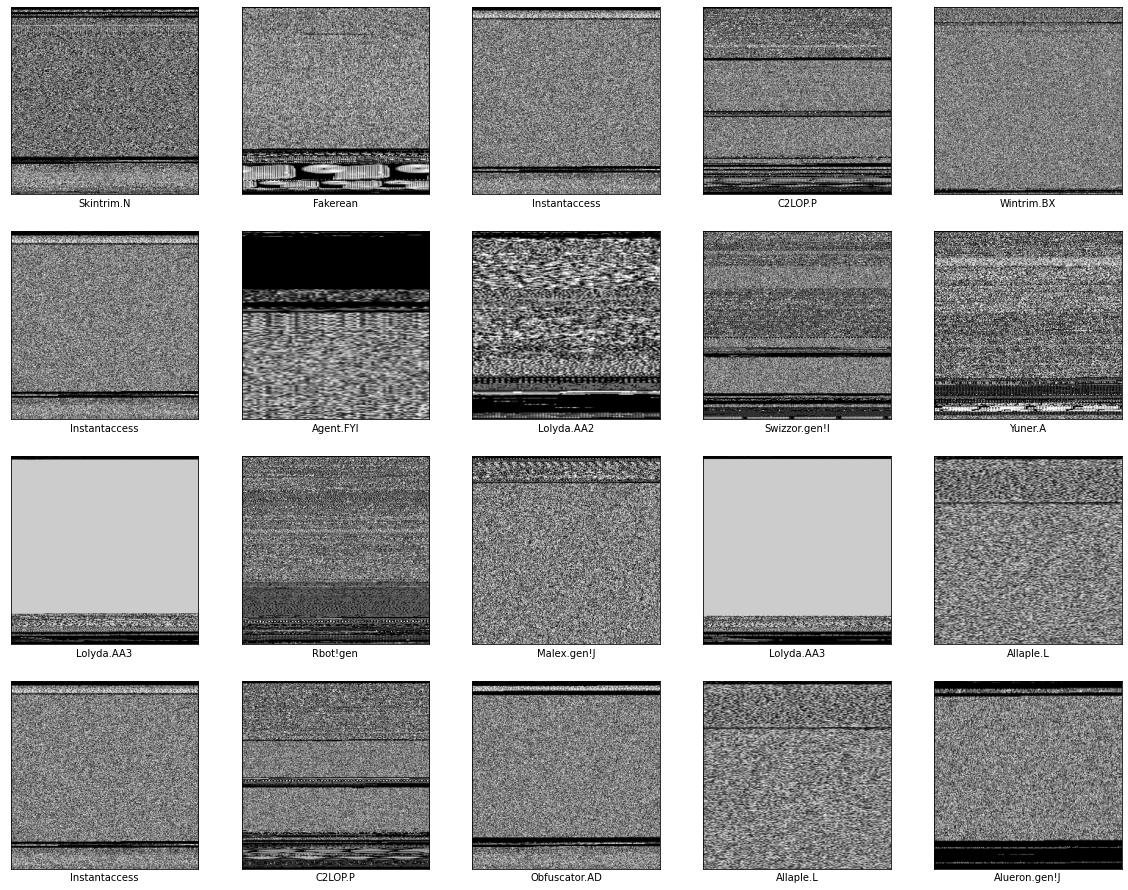

In [6]:
to_show = data.sample(20)

fig_size = (20, 20)
fig = plt.figure(figsize=fig_size)

id = 0
for index, row in to_show.iterrows():
  plt.subplot(5, 5, id + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

  plt.imshow(row['image'].astype(np.uint8))
  plt.xlabel(row['familyName'])
  id += 1

plt.show()

# Manipulacion de la data

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [8]:
data.iloc[0]

id                                                            0
familyId                                                      0
familyName                                            Adialer.C
file                       000bde2e9a94ba41c0c111ffd80647c2.png
path          ./data/Adialer.C/000bde2e9a94ba41c0c111ffd8064...
height                                                      410
width                                                       512
image         [[[87.0, 87.0, 87.0], [50.0, 50.0, 50.0], [3.0...
Name: 0, dtype: object

In [26]:
total_classes = np.unique(data.familyName)
number_of_total_classes = len(total_classes)
number_of_total_classes

25

In [9]:
images = []

for index, row in data.iterrows():
    images.append(row["image"].astype(float))

images =  np.array(images)

In [10]:
len(images)

4909

In [27]:
x_train = images

In [28]:
y_train = data.iloc[:, 0].values.astype('int32')

In [29]:
y = np.zeros((len(data),25))
for index, row in data.iterrows():
  y[index][row['familyId']] = 1
print(len(y))

4909


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '1.0')

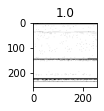

In [31]:
plt.subplot(331)
plt.imshow(x_train[1], cmap=plt.get_cmap('gray'))
plt.title(y[1][0])

In [32]:
print('Train:', x_train.shape, y.shape)

Train: (4909, 256, 256, 3) (4909, 25)


# Desarrollo del modelo

In [33]:
# X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.30, random_state=42)

In [34]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (3436, 256, 256, 3) (3436, 25)
Test: (1473, 256, 256, 3) (1473, 25)


In [35]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D

In [19]:
# model = Sequential()

# model.add(Flatten(input_shape=(DIMENSION, DIMENSION, 3)))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(10))

# print('input shape', model.input_shape)
# print('output shape', model.output_shape)

In [36]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), strides=(1, 1), input_shape=(DIMENSION, DIMENSION, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(25, activation='sigmoid'))
print('input shape', model.input_shape)
print('output shape', model.output_shape)

input shape (None, 256, 256, 3)
output shape (None, 25)


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_2 (Dense)             (None, 512)              

In [38]:
model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [49]:
history=model.fit(
  x=X_train,
  y=y_train,
  epochs=5,
  batch_size=16,
  validation_split=0.1,
  verbose=2
)

Epoch 1/5
194/194 - 136s - loss: 0.5138 - accuracy: 0.8839 - val_loss: 0.6002 - val_accuracy: 0.7994 - 136s/epoch - 701ms/step
Epoch 2/5
194/194 - 133s - loss: 0.4735 - accuracy: 0.8603 - val_loss: 0.6976 - val_accuracy: 0.8227 - 133s/epoch - 685ms/step
Epoch 3/5
194/194 - 131s - loss: 0.3146 - accuracy: 0.8988 - val_loss: 0.8604 - val_accuracy: 0.8983 - 131s/epoch - 676ms/step
Epoch 4/5
194/194 - 131s - loss: 0.2828 - accuracy: 0.9243 - val_loss: 0.8831 - val_accuracy: 0.8576 - 131s/epoch - 677ms/step
Epoch 5/5
194/194 - 135s - loss: 0.1816 - accuracy: 0.9483 - val_loss: 0.6936 - val_accuracy: 0.9244 - 135s/epoch - 693ms/step


In [58]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

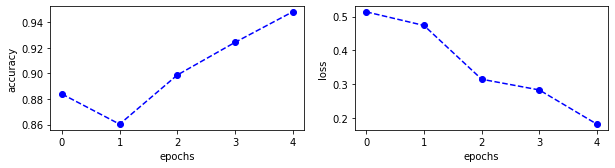

In [59]:
fig = plt.figure(figsize=(10,5))

# Plot accuracy
plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label='acc')
plt.ylabel('accuracy')
plt.xlabel('epochs') 

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label='loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [60]:
y_preds = model.predict(X_test, verbose=0)

In [61]:
def getCategory(data):
  y_prediction = []
  for item in data:
    max_value = max(item)
    max_index = list(item).index(max_value)
    y_prediction.append(max_index)
  return np.array(y_prediction).astype('int64')

y_prediction = getCategory(y_preds)
y_validation = getCategory(y_test)

## Metricas

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score

In [63]:
print(classification_report(y_prediction, y_validation))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64        85
           1       1.00      0.90      0.95        48
           2       0.89      0.76      0.82       125
           3       0.98      0.95      0.96       101
           4       1.00      0.64      0.78        87
           5       1.00      0.75      0.86        53
           6       0.65      0.42      0.51        84
           7       0.29      0.21      0.25        71
           8       1.00      1.00      1.00        57
           9       0.00      0.00      0.00         0
          10       0.68      1.00      0.81        74
          11       1.00      1.00      1.00       137
          12       0.97      0.97      0.97        64
          13       0.79      1.00      0.88        34
          14       0.97      1.00      0.99        39
          15       1.00      0.83      0.91        47
          16       0.89      0.87      0.88        38
          17       1.00    

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [64]:
confusion_matrix(y_validation, y_prediction)

array([[ 40,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  43,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  95,   2,   0,   0,   4,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   4,   0,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,   2,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  56,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  40,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   2,   0,   0,   0,  35,   8,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0,   5,   3,   0,   0,   0],
      

In [65]:
accuracy_score(y_validation, y_prediction)

0.7875084860828242

# Discusion
- Se cree que la razon de tener un accuracy de 0.695 se debe a que se hace resize de las imagenes, por lo que se pierde información al no tenerlas todas del mismo tamaño
- Otra razón, es que no se sabe si se están usando las mejores capas para el modelo ya que no existe un "tunning" para obtener las mejores métricas según las posibles combinaciones
- Es posible que el mejor approach fuera crear modelos distintos por cada tamaño de imagen y así tener imagenes de la misma calidad por cada modelo y no perder información para obtener mejores métricas